#Hands-on Tutorial on Heterogeneous Graph Neural Networks (Introduction)

## Machine Learning and Dynamical Systems Seminar hosted by the Alan Turing Institute

In [25]:
%%capture
!pip install torch torchvision torch-geometric
!pip install rdflib

## Imports

In [26]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import RGCNConv
from torch_geometric.datasets import Entities
import torch.nn.functional as F
from torch_geometric.utils import k_hop_subgraph

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Create a simple Heterogeneous graph for visualization

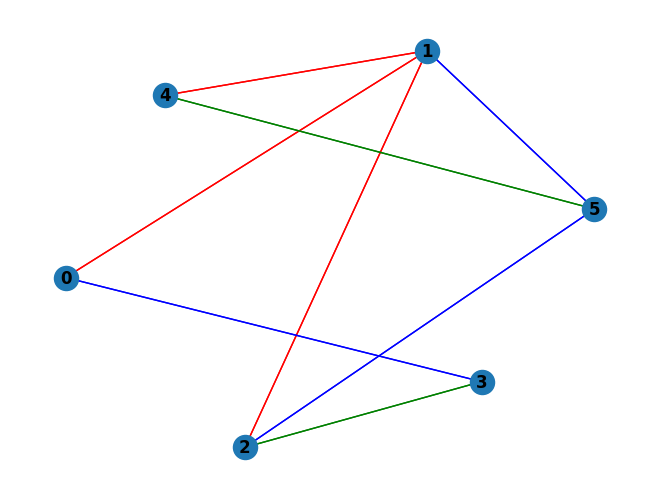

In [27]:
# 3 edge types
edge_index = torch.tensor([[0, 1, 1, 2, 1, 4, 2, 3, 4, 5, 0, 3, 2, 5, 1, 5],
                           [1, 0, 2, 1, 4, 1, 3, 2, 5, 4, 3, 0, 5, 2, 5, 1]], dtype=torch.long)
edge_type = torch.tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2], dtype=torch.long)

# Create data object
data = Data(edge_index=edge_index, edge_type=edge_type)

# Create a graph with Networkx
G = nx.Graph()

G.add_nodes_from(range(data.edge_index.max().item() + 1))

# Add edge colors
edge_colors = {0: 'r', 1: 'g', 2: 'b'}
edges = [(data.edge_index[0, i].item(), data.edge_index[1, i].item()) for i in range(data.edge_index.size(1))]

# Draw graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', edgelist=edges, edge_color=[edge_colors[data.edge_type[i].item()] for i in range(data.edge_type.size(0))])

# Show plot
plt.show()

## Download datasets

In [28]:
dataset = Entities(root='.', name="AIFB")
data = dataset[0]
data

Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285)

In [29]:
torch.unique(data.train_y)

tensor([0, 1, 2, 3])

In [30]:
torch.unique(data.edge_type)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89])

### Datasets from Entities are quite big, so we only take into account the 2-hop neighbors of test and training nodes

In [31]:
node_idx = torch.cat([data.train_idx, data.test_idx], dim=0)
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 2, data.edge_index, relabel_nodes=True)

data.num_nodes = node_idx.size(0)
data.edge_index = edge_index
data.edge_type = data.edge_type[edge_mask]
data.train_idx = mapping[:data.train_idx.size(0)]
data.test_idx = mapping[data.train_idx.size(0):]

data


Data(edge_index=[2, 54024], edge_type=[54024], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=6909)

## Relational Graph Convolutional Network

![](./SCM_XAITutorial.png)

In [32]:
hidden_dimension = 16

class HeterogeneousNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = RGCNConv(data.num_nodes, hidden_dimension, dataset.num_relations)
        self.conv2 = RGCNConv(hidden_dimension, dataset.num_classes, dataset.num_relations)

    def forward(self, edge_index, edge_type):
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)

In [33]:
model = HeterogeneousNetwork().to(device)
model
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)

## Training procedure




In [34]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.edge_index, data.edge_type)
    loss = F.nll_loss(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.edge_index, data.edge_type).argmax(dim=-1)
    train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
    test_acc = float((pred[data.test_idx] == data.test_y).float().mean())
    return train_acc, test_acc


for epoch in range(1, 30):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} '
          f'Test: {test_acc:.4f}')

Epoch: 01, Loss: 1.3873, Train: 0.9143 Test: 0.8056
Epoch: 02, Loss: 0.8931, Train: 0.9429 Test: 0.8889
Epoch: 03, Loss: 0.5460, Train: 0.9571 Test: 0.9444
Epoch: 04, Loss: 0.3240, Train: 0.9643 Test: 0.9444
Epoch: 05, Loss: 0.1978, Train: 0.9714 Test: 0.9444
Epoch: 06, Loss: 0.1284, Train: 0.9786 Test: 0.9444
Epoch: 07, Loss: 0.0887, Train: 0.9857 Test: 0.9722
Epoch: 08, Loss: 0.0638, Train: 0.9857 Test: 0.9722
Epoch: 09, Loss: 0.0467, Train: 0.9857 Test: 0.9722
Epoch: 10, Loss: 0.0342, Train: 0.9857 Test: 0.9722
Epoch: 11, Loss: 0.0247, Train: 1.0000 Test: 0.9722
Epoch: 12, Loss: 0.0175, Train: 1.0000 Test: 0.9722
Epoch: 13, Loss: 0.0124, Train: 1.0000 Test: 0.9722
Epoch: 14, Loss: 0.0091, Train: 1.0000 Test: 0.9444
Epoch: 15, Loss: 0.0071, Train: 1.0000 Test: 0.9444
Epoch: 16, Loss: 0.0058, Train: 1.0000 Test: 0.9444
Epoch: 17, Loss: 0.0049, Train: 1.0000 Test: 0.9444
Epoch: 18, Loss: 0.0042, Train: 1.0000 Test: 0.9444
Epoch: 19, Loss: 0.0036, Train: 1.0000 Test: 0.9444
Epoch: 20, L

### Check the number of parameters: we have 90 matrices of dimensions [6909 x 16]




In [35]:
model.conv1.weight.shape



torch.Size([90, 6909, 16])

## Relational Graph Convolutional Network with basis learning

In [40]:
class HeterogeneousNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = RGCNConv(data.num_nodes, hidden_dimension, dataset.num_relations,
                          num_bases=30)
        self.conv2 = RGCNConv(hidden_dimension, dataset.num_classes, dataset.num_relations,
                          num_bases=30)

    def forward(self, edge_index, edge_type):
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)

In [42]:
model = HeterogeneousNetwork().to(device)
model
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)

## Training procedure

In [43]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.edge_index, data.edge_type)
    loss = F.nll_loss(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.edge_index, data.edge_type).argmax(dim=-1)
    train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
    test_acc = float((pred[data.test_idx] == data.test_y).float().mean())
    return train_acc, test_acc


for epoch in range(1, 30):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} '
          f'Test: {test_acc:.4f}')

Epoch: 01, Loss: 1.3944, Train: 0.9143 Test: 0.8056
Epoch: 02, Loss: 0.7544, Train: 0.9429 Test: 0.8889
Epoch: 03, Loss: 0.3077, Train: 0.9571 Test: 0.8889
Epoch: 04, Loss: 0.1491, Train: 0.9714 Test: 0.9444
Epoch: 05, Loss: 0.0882, Train: 0.9857 Test: 0.9444
Epoch: 06, Loss: 0.0552, Train: 0.9857 Test: 0.9444
Epoch: 07, Loss: 0.0343, Train: 0.9857 Test: 0.9444
Epoch: 08, Loss: 0.0201, Train: 1.0000 Test: 0.9444
Epoch: 09, Loss: 0.0118, Train: 1.0000 Test: 0.9444
Epoch: 10, Loss: 0.0076, Train: 1.0000 Test: 0.9444
Epoch: 11, Loss: 0.0053, Train: 1.0000 Test: 0.9444
Epoch: 12, Loss: 0.0035, Train: 1.0000 Test: 0.9444
Epoch: 13, Loss: 0.0022, Train: 1.0000 Test: 0.9444
Epoch: 14, Loss: 0.0013, Train: 1.0000 Test: 0.9444
Epoch: 15, Loss: 0.0008, Train: 1.0000 Test: 0.9444
Epoch: 16, Loss: 0.0005, Train: 1.0000 Test: 0.9444
Epoch: 17, Loss: 0.0004, Train: 1.0000 Test: 0.9444
Epoch: 18, Loss: 0.0003, Train: 1.0000 Test: 0.9444
Epoch: 19, Loss: 0.0003, Train: 1.0000 Test: 0.9444
Epoch: 20, L

### Check the number of parameters: we have 30 matrices of dimensions [6909 x 16]

We have reduced them by specifying the parameter

```
num_bases = 30
```
inside the network



In [44]:
model.conv1.weight.shape

torch.Size([30, 6909, 16])